In [1]:
pip install prophet

   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.1/13.3 MB 1.1 MB/s eta 0:00:13
    --------------------------------------- 0.2/13.3 MB 2.5 MB/s eta 0:00:06
   - -------------------------------------- 0.3/13.3 MB 3.0 MB/s eta 0:00:05
   - -------------------------------------- 0.6/13.3 MB 3.5 MB/s eta 0:00:04
   --- ------------------------------------ 1.1/13.3 MB 5.4 MB/s eta 0:00:03
   ---- ----------------------------------- 1.6/13.3 MB 6.3 MB/s eta 0:00:02
   ---- ----------------------------------- 1.6/13.3 MB 6.4 MB/s eta 0:00:02
   ----- ---------------------------------- 1.9/13.3 MB 5.9 MB/s eta 0:00:02
   --------- ------------------------------ 3.0/13.3 MB 8.0 MB/s eta 0:00:02
   ---------- ----------------------------- 3.5/13.3 MB 8.6 MB/s eta 0:00:02
   ----------- ---------------------------- 4.0/13.3 MB 8.8 MB/s eta 0:00:02
   ------------- -------------------------- 4.4/13.3 MB 9.0 MB/s eta 0:00:01
   ---

In [2]:
import pandas as pd

C:\Users\User\AppData\Local\Temp\ipykernel_10100\4080736814.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
from pandas.api.types import CategoricalDtype

In [4]:
from prophet import Prophet

In [5]:
import requests

In [8]:
from bs4 import BeautifulSoup

In [9]:
import matplotlib.pyplot as plt

In [10]:
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error

In [11]:
import warnings;

In [12]:
warnings.filterwarnings('ignore')

In [29]:
import seaborn as sns

In [30]:
url = 'https://cbr.ru/hd_base/KeyRate/?UniDbQuery.Posted=True&UniDbQuery.From=17.09.2013&UniDbQuery.To=29.05.2024'

In [56]:
url = 'https://cbr.ru/hd_base/KeyRate/?UniDbQuery.Posted=True&UniDbQuery.From=17.09.2013&UniDbQuery.To=29.05.2024'
data = requests.get(url).text
beautiful_soup = BeautifulSoup(data,'html.parser')
tables = beautiful_soup.find_all("table")
df = pd.read_html(str(tables))[0]
df['Ставка'] /= 100
df.columns = ['datetime','key_rate']
df['datetime'] = pd.to_datetime(df['datetime'],format = '%d.%m.%Y')
df

,datetime,key_rate
0,2024-05-29,16.0
1,2024-05-28,16.0
2,2024-05-27,16.0
3,2024-05-24,16.0
4,2024-05-23,16.0
...,...,...
2668,2013-09-23,5.5
2669,2013-09-20,5.5
2670,2013-09-19,5.5
2671,2013-09-18,5.5


In [46]:
df['year'] = df['datetime'].apply(lambda x:x[-2:])
df.sort_values('year',inplace = True)

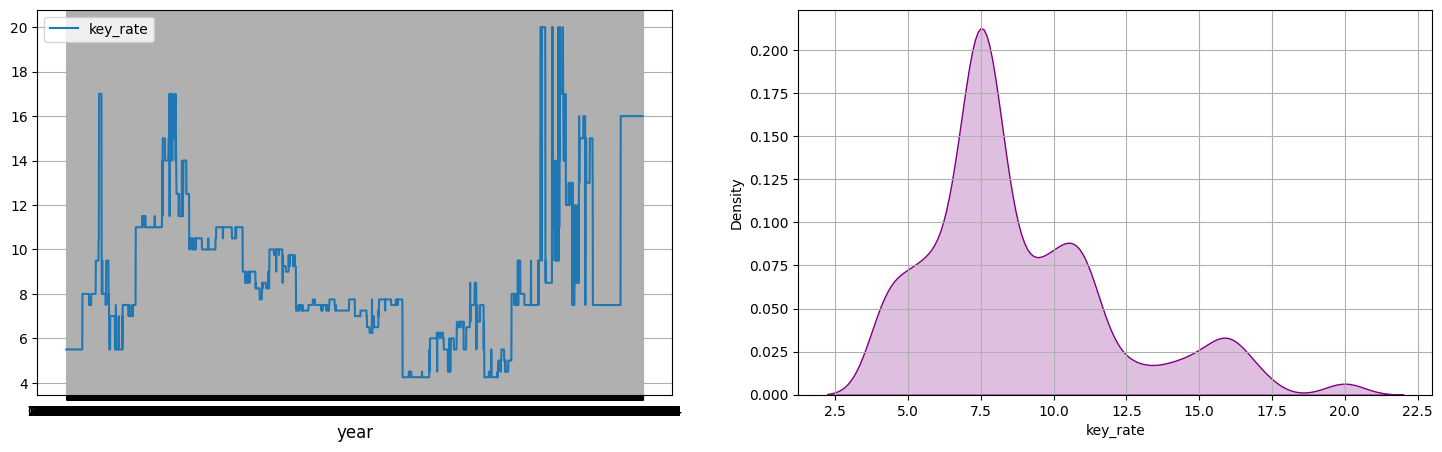

In [52]:
fig,axes = plt.subplots(1,2,figsize = (18,5))
axes[0].plot(df[df.columns[0]],df[df.columns[1]],label = 'key_rate')
axes[0].set_xlabel(df.columns[2],fontsize = 12)
axes[0].legend(loc = 'best')
axes[0].grid(True)

sns.kdeplot(df[df.columns[1]],ax = axes[1],color = 'purple',fill = True)
axes[1].grid(True)
plt.show()

In [66]:
def create_features(data_full,col_datetime):
    data = data_full.copy()
    data['weekday'] = data[col_datetime].dt.day_name().astype(cat_type)
    data['quater'] = data['datetime'].dt.quarter
    data['month'] = data[col_datetime].dt.month
    data['year'] = data[col_datetime].dt.year
    data['date_offset'] = (data[col_datetime].dt.month*100+data.datetime.dt.day - 320)%1300
    data['season'] = pd.cut(data['date_offset'],[0,300,602,900,1300],
                           labels = ['Spring','Summer','Fall','Winter'])
    return data
cat_type = CategoricalDtype(categories = [
    'Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'
], ordered = True)
df_features = create_features(data_full = df,col_datetime = 'datetime')
                        

In [67]:
df_features

,datetime,key_rate,weekday,quater,month,year,date_offset,season
0,2024-05-29,16.0,Wednesday,2,5,2024,209,Spring
1,2024-05-28,16.0,Tuesday,2,5,2024,208,Spring
2,2024-05-27,16.0,Monday,2,5,2024,207,Spring
3,2024-05-24,16.0,Friday,2,5,2024,204,Spring
4,2024-05-23,16.0,Thursday,2,5,2024,203,Spring
...,...,...,...,...,...,...,...,...
2668,2013-09-23,5.5,Monday,3,9,2013,603,Fall
2669,2013-09-20,5.5,Friday,3,9,2013,600,Summer
2670,2013-09-19,5.5,Thursday,3,9,2013,599,Summer
2671,2013-09-18,5.5,Wednesday,3,9,2013,598,Summer


In [68]:
df_features.sort_values('datetime',inplace = True)


In [71]:
df_features = df_features.reset_index(drop = True)

In [72]:
df_features

,datetime,key_rate,weekday,quater,month,year,date_offset,season
0,2013-09-17,5.5,Tuesday,3,9,2013,597,Summer
1,2013-09-18,5.5,Wednesday,3,9,2013,598,Summer
2,2013-09-19,5.5,Thursday,3,9,2013,599,Summer
3,2013-09-20,5.5,Friday,3,9,2013,600,Summer
4,2013-09-23,5.5,Monday,3,9,2013,603,Fall
...,...,...,...,...,...,...,...,...
2668,2024-05-23,16.0,Thursday,2,5,2024,203,Spring
2669,2024-05-24,16.0,Friday,2,5,2024,204,Spring
2670,2024-05-27,16.0,Monday,2,5,2024,207,Spring
2671,2024-05-28,16.0,Tuesday,2,5,2024,208,Spring


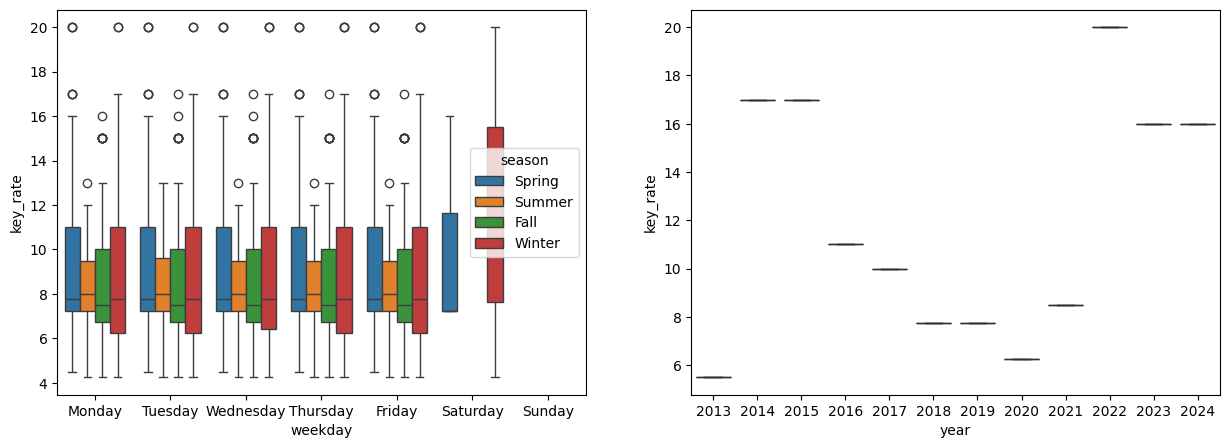

In [73]:
fig,axes = plt.subplots(1,2,figsize=(15,5))
sns.boxplot(
    data = df_features,
    x = 'weekday',
    y = 'key_rate',
    hue = 'season',
    ax = axes[0],
    linewidth = 1
)
axes[0].set_xlabel('weekday')
axes[0].set_ylabel('key_rate')
yearAgregated = pd.DataFrame(df_features.groupby(
    'year')['key_rate'].max()).reset_index().sort_values('key_rate')
sns.boxplot(data = yearAgregated,x = 'year',y = 'key_rate',palette = 'crest')
plt.show()

In [74]:
#в среднем весной больше (синие всегда повыше) в субботу аномадии

In [75]:
df_features[df_features['weekday'] == 'Saturday']

,datetime,key_rate,weekday,quater,month,year,date_offset,season
601,2016-02-20,11.00,Saturday,1,2,2016,1200,Winter
1141,2018-04-28,7.25,Saturday,2,4,2018,108,Spring
1168,2018-06-09,7.25,Saturday,2,6,2018,289,Spring
1844,2021-02-20,4.25,Saturday,1,2,2021,1200,Winter
2108,2022-03-05,20.00,Saturday,1,3,2022,1285,Winter
2651,2024-04-27,16.00,Saturday,2,4,2024,107,Spring


In [79]:
df_features[2108:2115]

,datetime,key_rate,weekday,quater,month,year,date_offset,season
2108,2022-03-05,20.0,Saturday,1,3,2022,1285,Winter
2109,2022-03-09,20.0,Wednesday,1,3,2022,1289,Winter
2110,2022-03-10,20.0,Thursday,1,3,2022,1290,Winter
2111,2022-03-11,20.0,Friday,1,3,2022,1291,Winter
2112,2022-03-14,20.0,Monday,1,3,2022,1294,Winter
2113,2022-03-15,20.0,Tuesday,1,3,2022,1295,Winter
2114,2022-03-16,20.0,Wednesday,1,3,2022,1296,Winter


In [80]:
drop_idx = df_features[df_features['weekday'] == 'Saturday'].index
df = df[~df.index.isin(drop_idx)]
df = df.reset_index(drop=True)
df

,datetime,key_rate
0,2024-05-29,16.0
1,2024-05-28,16.0
2,2024-05-27,16.0
3,2024-05-24,16.0
4,2024-05-23,16.0
...,...,...
2662,2013-09-23,5.5
2663,2013-09-20,5.5
2664,2013-09-19,5.5
2665,2013-09-18,5.5


Моделирование 

Prophet Model

In [98]:
df.columns = ['ds','y']
size = int(df.shape[0]*0.1)
df = df.sort_values('ds')
train_df = df[:-size]
test_df = df[-size:]

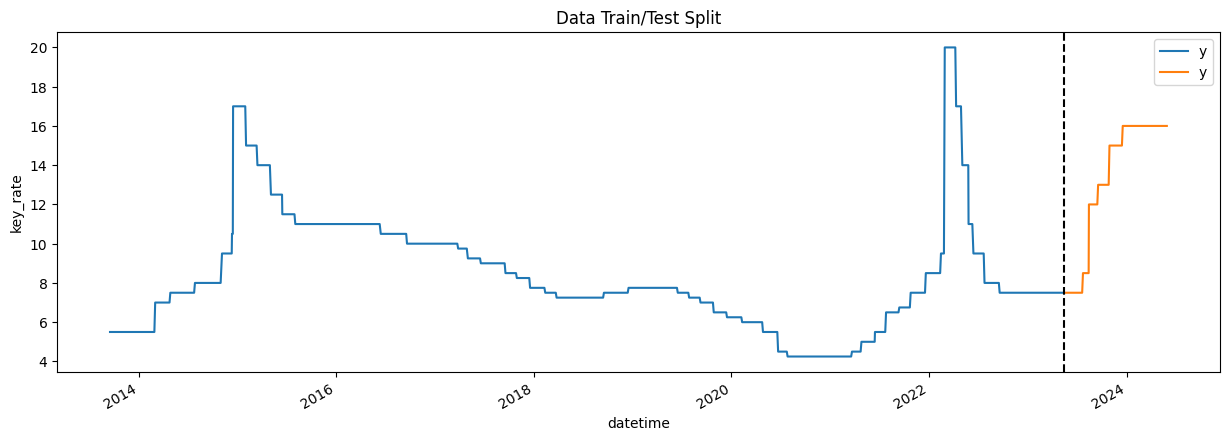

In [99]:
fig,ax = plt.subplots(figsize = (15,5))

train_df.set_index('ds').plot(
    ax=ax,
    label = 'Train',
    title = 'Data Train/Test Split'
)
test_df.set_index('ds').plot(ax=ax,label = 'Test')
ax.axvline(train_df['ds'][-1:].values,color = 'black',ls='--')
ax.set_ylabel('key_rate')
ax.set_xlabel('datetime')
plt.show()

In [100]:
model = Prophet()
model.fit(train_df)

02:40:41 - cmdstanpy - INFO - Chain [1] start processing
02:40:42 - cmdstanpy - INFO - Chain [1] done processing


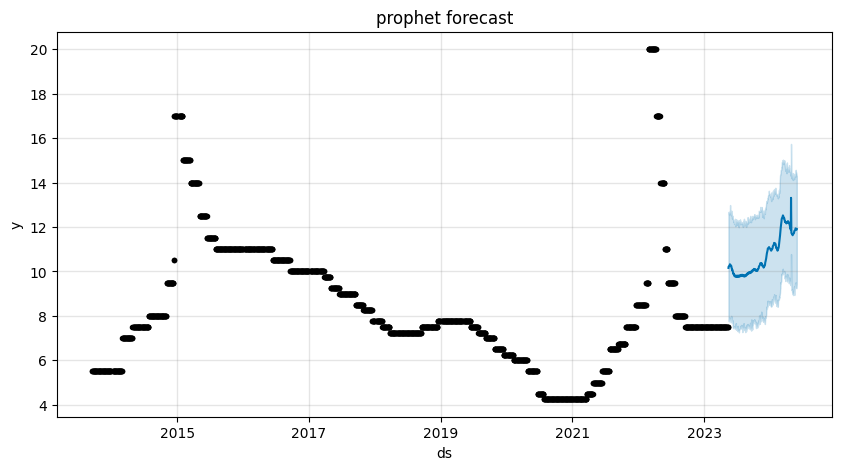

In [102]:
fig,ax = plt.subplots(figsize = (10,5))
predict = model.predict(test_df)
fig = model.plot(predict,ax = ax)
ax.set_title('prophet forecast')
plt.show()

синим - прогноз

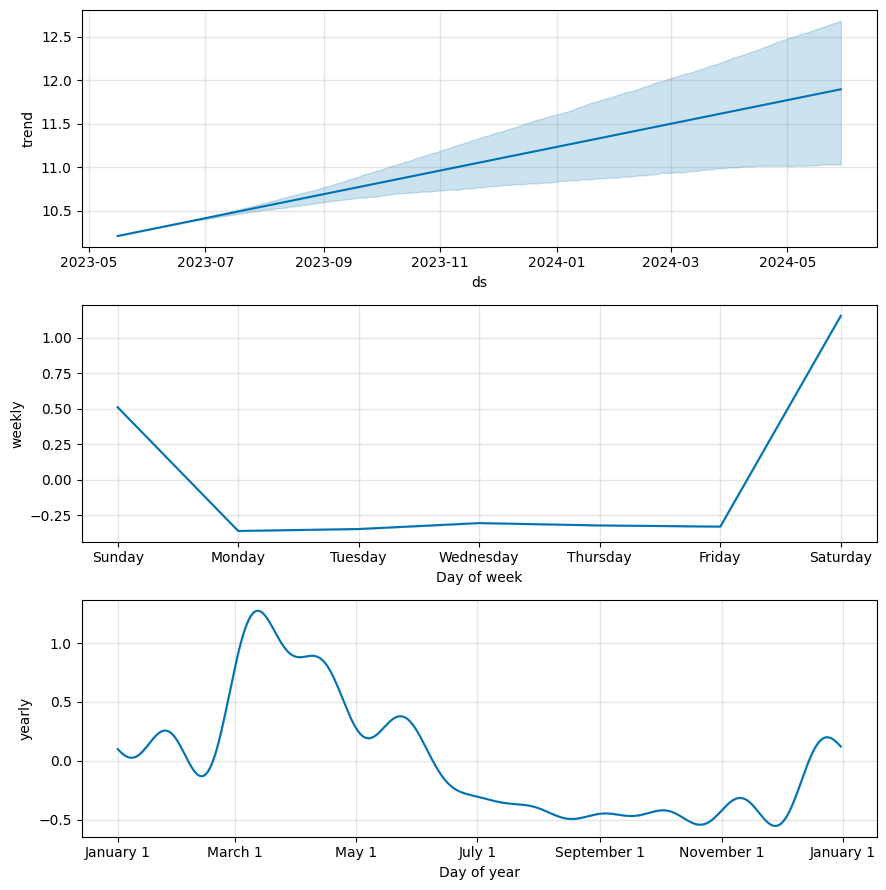

In [103]:
fig = model.plot_components(predict)
plt.show()

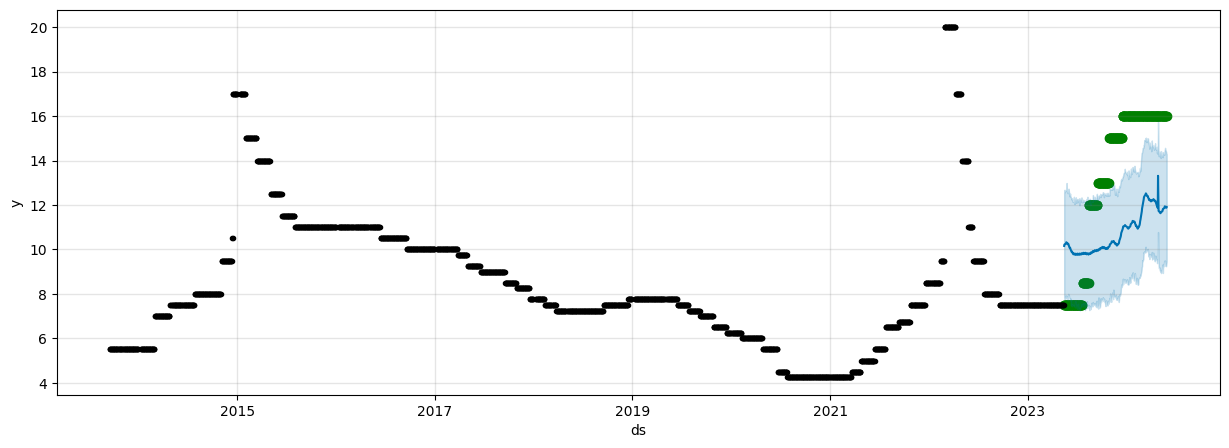

In [105]:
f,ax = plt.subplots(figsize = (15,5))

ax.scatter(test_df['ds'],test_df['y'],color = 'g')
fig = model.plot(predict,ax=ax)

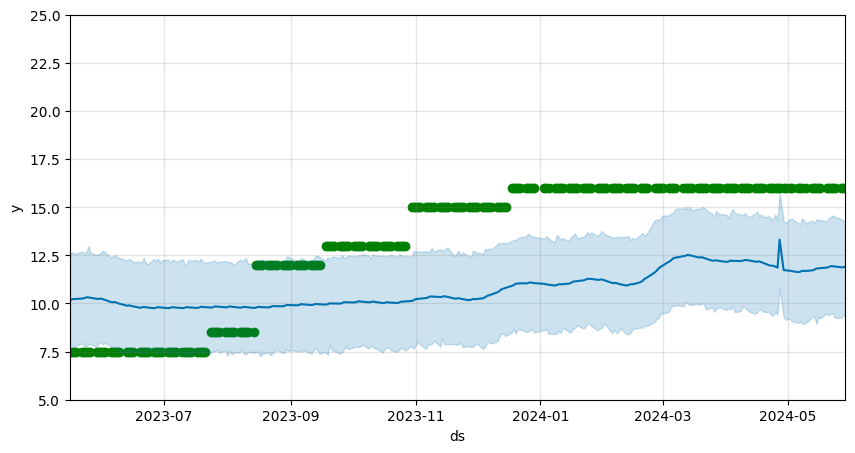

In [116]:
fig, ax = plt.subplots(figsize = (10,5))

ax.scatter(test_df['ds'],test_df['y'],color = 'g')
fig = model.plot(predict,ax=ax)
ax.set_xbound(lower = test_df['ds'][:1].values,
              upper = test_df['ds'][-1:].values)
ax.set_ylim(5,25)
plt.show()

Рассчет метрик

In [118]:
df_test_null = test_df.copy()
df_test_null['y'] = None
df_pred = pd.concat([train_df,df_test_null])
pred = model.predict(df_pred)


In [120]:
MAE = mean_absolute_error(y_true = test_df['y'],
                          y_pred = pred['yhat'][train_df.shape[0]:])
MAE

3.498365291788519

In [121]:
MAPE = mean_absolute_percentage_error(y_true = test_df['y'],
                          y_pred = pred['yhat'][train_df.shape[0]:])

In [122]:
MAPE

0.26572662109364936

Predict into the Future 2024

In [123]:
model_full = Prophet()
model_full.fit(df)

02:54:02 - cmdstanpy - INFO - Chain [1] start processing
02:54:03 - cmdstanpy - INFO - Chain [1] done processing


In [126]:
future = model_full.make_future_dataframe(periods = 200,freq = 'D')#формирует на 200 дней вперед
forecast = model_full.predict(future)

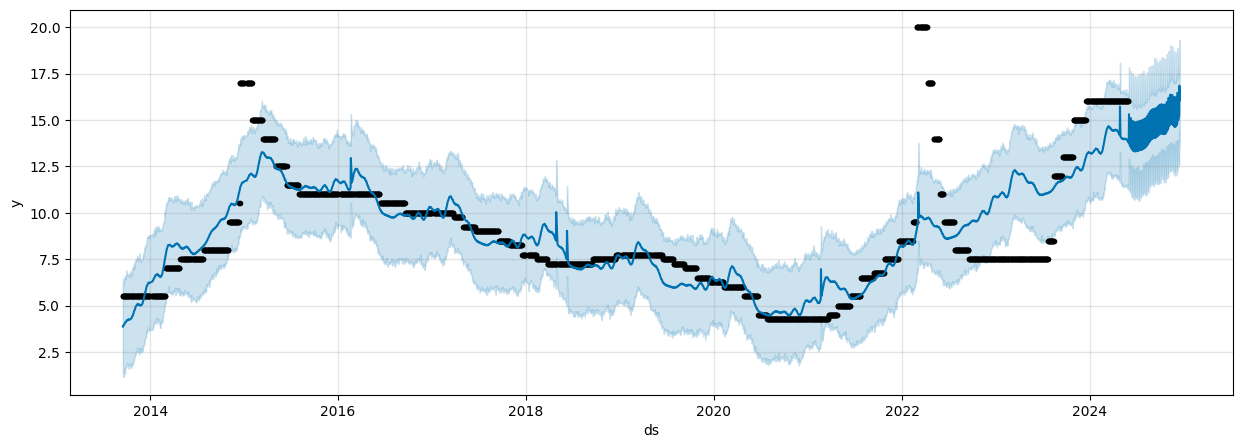

In [125]:
f,ax = plt.subplots(figsize = (15,5))
fig = model_full.plot(forecast,ax=ax)